In [177]:
# import libraries
import pandas as pd
import numpy as np
import time
import pickle
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
pd.plotting.register_matplotlib_converters()

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import tree
# from sklearn.cross_validation import KFold, cross_val_score

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_curve

from sklearn import datasets, linear_model, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier


import scikitplot as skplt
import matplotlib.pyplot as plt

## I. DATA Processing

https://www.kaggle.com/henriqueyamahata/bank-marketing

In [7]:
def remove_duplicated_row(df):
    df = df.drop(df[df.duplicated()].index).reset_index(drop=True)
    return(df)

def remove_features(df,col_lst):
    for col in col_lst:
        df.pop(col)
    return(df)

def replace_missing_by_value(df,column,replaced_value,missing_value='unknown'):
    df[column] = df[column].apply(lambda val: replaced_value if val == missing_value else val)
    return df

def replace_outlier_by_quantile(df, column, quantile_thresh = 0.95, replaced_value = None):
    thresh_value = df[column].quantile(quantile_thresh)
    if (replaced_value == None):
        replaced_value = thresh_value
        
    df[column] = df[column].apply(lambda val: replaced_value if val > thresh_value  else val)
    return df

def replace_outlier_by_value(df, column, value_thresh, replaced_value = None):
    if (replaced_value == None):
        replaced_value = value_thresh
        
    df[column] = df[column].apply(lambda val: replaced_value if val > value_thresh else val)
    return df

def replace_missing_by_mode(df,column,missing_value='unknown'):
    replaced_value = df[column].mode().values.tolist()[0]
    df[column] = df[column].apply(lambda val: replaced_value if val == missing_value else val)
    
    return df

def replace_missing_by_median(df,column,missing_value='unknown'):
    replaced_value = df[column].median().values.tolist()[0]
    df[column] = df[column].apply(lambda val: replaced_value if val == missing_value else val)
    return df

def transform_pdays(val):
    transform_dict = {999:'not_previously_contacted',7: 'over_a_week',0:'within_a_week'}
    for key in transform_dict.keys():
        if (val >= key):
            return transform_dict[key]

def eval_class(true, predicted):
    acc = metrics.accuracy_score(true, predicted)
    precision = metrics.precision_score(true, predicted)
    recall = metrics.recall_score(true, predicted)
    f1 = metrics.f1_score(true, predicted)
    log_loss = metrics.log_loss(true, predicted)
    auc = metrics.roc_auc_score(true, predicted)
    return acc, precision, recall, f1, log_loss, auc

def create_evaluation_df(model_name, y_train,y_train_pred, y_test, y_test_pred):
    eval_clm_metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'Log_loss','AUC']
    eval_clm_train = [m + '_train' for m in eval_clm_metrics]
    eval_clm_test = [m + '_test' for m in eval_clm_metrics]
    dis_clm = ['Model','Accuracy_train'] + eval_clm_test + ['diff_Acc_train_test']
    dis_clm_1 = ['Model','Accuracy_train','Accuracy_test','Precision_test','Recall_test','F1_test']
  
    res_clm = pd.DataFrame(data=[[model_name,*eval_class(y_train,y_train_pred),
                                 *eval_class(y_test, y_test_pred)]],
                          columns=['Model'] + eval_clm_train + eval_clm_test)
    res_clm['diff_Acc_train_test'] = res_clm.apply(lambda x: (x.Accuracy_test - x.Accuracy_train)/x.Accuracy_train, axis=1)
    
    return(res_clm[dis_clm_1])

def init_evaluation_df():
    eval_clm_metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'Log_loss','AUC']
    eval_clm_train = [m + '_train' for m in eval_clm_metrics]
    eval_clm_test = [m + '_test' for m in eval_clm_metrics]
    dis_clm = ['Model','Accuracy_train'] + eval_clm_test + ['diff_Acc_train_test']
    dis_clm_1 = ['Model','Accuracy_train','Accuracy_test','Precision_test','Recall_test','F1_test']
    
    res_clm = pd.DataFrame( columns=['Model'] + eval_clm_train + eval_clm_test + ['diff_Acc_train_test'])

    return(res_clm[dis_clm_1])
        
def data_processing_pipeline(df):
    # remove duplicated rows
    df = remove_duplicated_row(df)
    
    # remove duration and nr.employed
#     remove_cols =['duration', 'nr.employed'] 
#     df = remove_features(df,remove_cols)
    
    # edu_unknown = 'unknown'
    column = 'education'
    replaced_value = df[column].mode().values.tolist()[0]
    df = replace_missing_by_value(df,column,replaced_value)

    # housing_unknown = 'unknown'
    column = 'housing'
    replaced_value  = 'yes' #df[column].mode().values.tolist()[0]
    df = replace_missing_by_value(df,column,replaced_value)

    # loan_unknown = 'unknown'
    column = 'loan'
    replaced_value  = 'no' # df[column].mode().values.tolist()[0]
    df = replace_missing_by_value(df,column,replaced_value)

    # marital_unknown = 'unknown'
    column = 'marital'
    replaced_value  = 'single' # df[column].mode().values.tolist()[0]
    df = replace_missing_by_value(df,column,replaced_value)

    # job_unknown = 'unknown'
    column = 'job'
    replaced_value  = 'student' # df[column].mode().values.tolist()[0]
    df = replace_missing_by_value(df,column,replaced_value)

    ## OUTlier
    # age
    value_thresh = 65
    column = 'age' 
    df = replace_outlier_by_value(df,column,value_thresh)

    # duration
    column = 'duration' 
    df =  replace_outlier_by_quantile(df, column)# replace by quantile_95
    
    # campain
    value_thresh = 6
    column = 'campaign' 
    df = replace_outlier_by_value(df,column,value_thresh)

    #previous
    remove_thresh = float(0.95)
    column = 'previous' 
    df = replace_outlier_by_quantile(df,column)

    #cons.conf.idx'
    remove_thresh = float(0.95)
    column = 'cons.conf.idx' 
    df = replace_outlier_by_quantile(df,column)

    ### PHÂN LOẠI LẠI BIẾN
    # pdays
    column = 'pdays'
    df[column] = df[column].map(transform_pdays)
    
    return df

def label_encode_pipeline(df, cat_col_lst):
    labelencoder = LabelEncoder()
    for column in cat_col_lst:
        df[column] = labelencoder.fit_transform(df[column])
    return(df)

def run_model(name,model, X_train, y_train, X_test, y_test):
    # model_eval_df : evaluation dataframe of model
    # y_test_pred_proba: kiểu np.array - dùng để vẽ roc curve
    
    train_model_time = 0 # đo thời gian chạy model
    model_eval_df = pd.DataFrame() # evaluation dataframe
    start_time = time.time()
    
    model.fit(X_train,y_train)
    
    end_time = time.time()
    y_test_pred = model.predict(X_test)
    y_test_pred_proba = model.predict_proba(X_test)[:,1] #Lấy xác suất phần 1 
    y_train_pred = model.predict(X_train)

    model_eval_df = create_evaluation_df(name, y_train,y_train_pred, y_test, y_test_pred)
    train_model_time =  end_time - start_time
    return(model_eval_df,y_test_pred_proba)    

def run_model_lst(name_lst,model_lst, X_train, y_train, X_test, y_test):
    evalutation_df = init_evaluation_df() # evaluation dataframe
    y_test_proba_df = pd.DataFrame() # y_test_proba for ROC curve

    for model,name in zip(model_lst,name_lst):
        model_eval_df,y_test_pred_proba = run_model(name,model, X_train, y_train, X_test, y_test)
        
        evalutation_df = evalutation_df.append(model_eval_df, ignore_index = True)
        y_test_proba_df[name] = y_test_pred_proba
    
    return(evalutation_df,y_test_proba_df)

### ROC CURVE

def visualize_ROC_curves(y_test,y_pred_proba_df):
    plt.figure(figsize = (15,6))
    plt.plot([0, 1], [0, 1], 'k--')

    # Generate ROC curve values: fpr, tpr, thresholds
    for col in y_pred_proba_df.columns:
        fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, y_pred_proba_df[col])
        plt.plot(fpr1, tpr1)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve: Successful Client Classifiers')
    plt.legend(['Base line']+ y_pred_proba_df.columns.tolist(), loc='lower right')
    plt.show()

### Recall - Precision CURVE
def visualize_RR_curves(y_test,y_pred_proba_df):
    plt.figure(figsize = (15,6))
    # plt.plot([0, 1], [0, 1], 'k--')

    for col in y_pred_proba_df.columns:
        precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_df[col])
        plt.plot(recall,precision)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall: Successful Client Classifier')
    plt.legend(y_test_pred_proba_df.columns.tolist()+['Gradient_Raw'], loc='lower right')
    plt.show()
    
### Calculate ROI
def calculate_roi(call_cnt, sale_cnt,cost_per_call, roi_per_success):
    return roi_per_success * sale_cnt  - cost_per_call * call_cnt

def get_real_roi(y_test, cost_per_call = 10, roi_per_success = 20):
    sale_cnt = (y_test == 1).sum()
    call_cnt = len(y_test)
    real_roi = calculate_roi(call_cnt, sale_cnt, cost_per_call, roi_per_success)
    return real_roi
    
def get_pred_roi(y_test, y_test_pred,cost_per_call = 10, roi_per_success = 20):
    sale_cnt = ((y_test == 1) & (y_test_pred == 1)).sum()
    call_cnt = sum((y_test_pred == 1))
    pred_roi = calculate_roi(call_cnt, sale_cnt, cost_per_call, roi_per_success)
    return pred_roi

def under_resample_data(data, target = 'y'):
    X = data.iloc[:, data.columns != target]
    y = data.iloc[:, data.columns == target]
    # Number of data points in the minority class
    number_records_yes = len(data[data.y == 1])
    yes_indices = np.array(data[data.y == 1].index)

    # Picking the indices of the normal classes
    no_indices = data[data.y == 0].index

    # Out of the indices we picked, randomly select "x" number (number_records_fraud)
    random_no_indices = np.random.choice(no_indices, number_records_yes, replace = False)
    random_no_indices = np.array(random_no_indices)

    # Appending the 2 indices
    under_sample_indices = np.concatenate([yes_indices,random_no_indices])

    # Under sample dataset
    under_sample_data = data.iloc[under_sample_indices,:]
    
    return( under_sample_data)

### L O A D   data

In [144]:
#### L O A D Data
file_path = "data/bank-additional-full.csv"
marketing_df = pd.read_csv(file_path,sep = ";")

### P R O C E S S I N G   data

In [145]:
process_mkt_df = marketing_df.copy() 
test_size = 0.2
target = 'y'

## Processing data
process_mkt_df = data_processing_pipeline(process_mkt_df)
cat_cols = process_mkt_df.dtypes[process_mkt_df.dtypes == 'object'].index
num_cols = process_mkt_df.dtypes[process_mkt_df.dtypes != 'object'].index

## label encoding
process_mkt_df = label_encode_pipeline(process_mkt_df, cat_cols)

## list of models
models = [LogisticRegression(max_iter = 300),
#           GaussianNB(),
          DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0),
#           RandomForestClassifier(n_estimators=1000, max_depth=3),
          GradientBoostingClassifier(n_estimators=1000, learning_rate=0.003),
          XGBClassifier(n_estimators=1000, learning_rate=0.003, use_label_encoder = False)
          ]
names = [ 'Logistic Regressor',
#              'Naive Bayes',
            'Decision Tree Classifier',
#          'Random Forest Classifier',
          'Gradient Boost Classifier',
          'XGBoost Classifier'
        ]

### R U N   with the whole data set

In [146]:
## split train set and test_set
X_train, X_test, y_train, y_test = train_test_split(process_mkt_df.drop('y',axis=1), process_mkt_df['y'],
                                                    test_size=test_size, random_state = 101)
## standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## init data frame of evalutation and y_pred_proba
evalutation_df = pd.DataFrame() # evaluation dataframe
y_test_pred_proba_df = pd.DataFrame() # y_test_proba for ROC curve

## run list of Models to choose the optimal model
evalutation_df,y_test_pred_proba_df = run_model_lst(names, models, X_train, y_train, X_test, y_test)
# evalutation_df

[11:05:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
# ## ghi vào file pickle
# with open("model/pkl_scaler.pkl","wb") as f:
#     pickle.dump(scaler,f)

### U N D E R  S A M P L E D   Dataset 

In [10]:
# main data set for training
under_mkt_df = under_resample_data(process_mkt_df, target = 'y')
# Showing ratio
print("Percentage of no clients: ", len(under_mkt_df[under_mkt_df[target] == 0])/len(under_mkt_df))
print("Percentage of yes clients: ", len(under_mkt_df[under_mkt_df[target] == 1])/len(under_mkt_df))
print("Total number of clients in resampled data: ", len(under_mkt_df))

### R U N   with the under resampled data set

In [148]:
## Split train and test undersampled dataset
X_under_train, X_under_test, y_under_train, y_under_test = train_test_split(under_mkt_df.drop(target,axis=1),under_mkt_df[target],
                                                                            test_size=test_size, random_state = 101)
print("")
print("Number transactions train dataset: ", len(X_under_train))
print("Number transactions test dataset: ", len(X_under_test))
print("Total number of transactions: ", len(X_under_train)+len(X_under_test))

## Standardize data
X_under_train = scaler.fit_transform(X_under_train)
X_under_test = scaler.transform(X_under_test)

## Run model list
suffix = ' with under resampled data'
under_names = [name + suffix for name in names ]
## init data frame of evalutation and y_pred_proba
under_evalutation_df = pd.DataFrame() # evaluation dataframe
y_under_test_pred_proba_df = pd.DataFrame() # y_test_proba for ROC curve

under_evalutation_df,y_under_test_pred_proba_df= run_model_lst(under_names, models, X_under_train, y_under_train
                                                               , X_under_test, y_under_test)
# under_evalutation_df


Number transactions train dataset:  7422
Number transactions test dataset:  1856
Total number of transactions:  9278
[11:09:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### C O M P A R E    when training on the whole dataset and the under- resampled dataset

In [149]:
evaluations = pd.DataFrame()
evaluations = evalutation_df.append(under_evalutation_df, ignore_index = True)
evaluations

,Model,Accuracy_train,Accuracy_test,Precision_test,Recall_test,F1_test
0,Logistic Regressor,0.908956,0.911729,0.724508,0.414110,0.527001
1,Decision Tree Classifier,0.906891,0.906872,0.603941,0.626789,0.615153
2,Gradient Boost Classifier,0.913692,0.912215,0.733945,0.408998,0.525279
3,XGBoost Classifier,0.925228,0.918771,0.702490,0.548057,0.615738
4,Logistic Regressor with under resampled data,0.867960,0.876616,0.874870,0.885021,0.879916
5,Decision Tree Classifier with under resampled ...,0.851657,0.848060,0.865934,0.831224,0.848224
6,Gradient Boost Classifier with under resampled...,0.881703,0.888470,0.869392,0.919831,0.893901
7,XGBoost Classifier with under resampled data,0.911479,0.892241,0.871032,0.926160,0.897751


### ROC curve   in case of  undersampled dataset

Vì ta cần tỉ lệ bỏ sót khách hàng thành công của mô hình phải thấp nên mặc dù accuracy score chạy trên toàn tập data cao hơn, ta sẽ chọn cách train trên tập under sampled data vì trường hợp này cho độ Precision, Recall, F1 score trên nhãn successful tốt hơn và accuracy score trên tập train và test của undersampled data cho kết quả khá khả quan (>80%).
* Mô hình còn có thể cải thiện kết quả tiếp nếu ta kFold-validaion, điều này sẽ được cải tiến ở phase sau

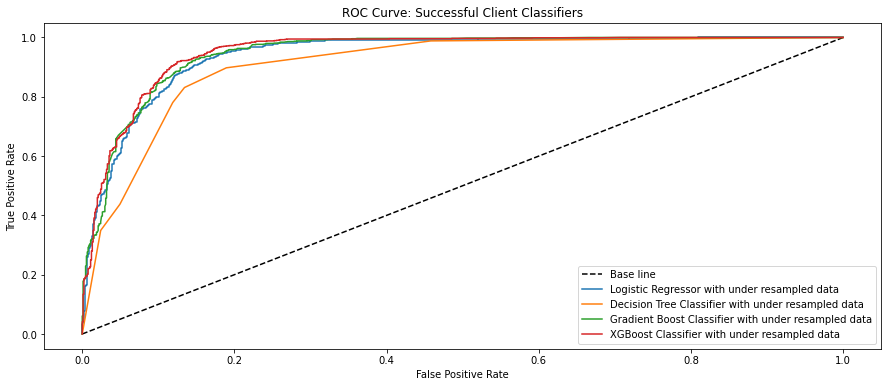

In [150]:
visualize_ROC_curves(y_under_test,y_under_test_pred_proba_df)

### K F O L D   validation to avoid improve the model's effectiveness

on undersampled by models( LogisticClf, DecisionTree, Random Forest Classifier, XGBoost)

In [61]:
# # scaler on the whole dataset
# scaler = pickle.load(open("model/pkl_scaler.pkl", 'rb'))

In [135]:
## init kfold
target = 'y'
num_fold = 5
kfold = KFold(n_splits=num_fold, shuffle=True)
# fold_scaler = StandardScaler()
X = scaler.transform(under_mkt_df.drop('y',axis=1))
y = under_mkt_df['y']

fold_idx = 1
fold_evalutation_df = pd.DataFrame()
fold_prob_df = pd.DataFrame()
for train_ids, val_ids in kfold.split(X, y):

    X_train = X[train_ids]
    X_val = X[val_ids]
    y_train = y.iloc[train_ids].values
    y_val = y.iloc[val_ids].values
    
    eval_df, y_prob_df= run_model_lst(names,models, X_train, y_train, X_val, y_val)
    
    
    
    eval_df['k_th_fold'] = fold_idx
    fold_evalutation_df= fold_evalutation_df.append(eval_df, ignore_index = True)
    
    new_names = [col+'_'+str(fold_idx) for col in y_prob_df.columns.tolist()]# đổi tên cột của y_prob_df
    y_prob_df.columns = new_names
    fold_prob_df = pd.concat([fold_prob_df, y_prob_df],axis=1)

    # Sang Fold tiếp theo
    fold_idx = fold_idx + 1

[10:58:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:58:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:58:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:59:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

### E V A L U A T E  to choose the optimal model with the best avarage metrics

In [154]:
# fold_evalutation_df.to_csv('fold_evalutation_df.csv')
# fold_evalutation_df
t = fold_evalutation_df.groupby(['Model']).mean().iloc[:,:-1].sort_values(['Recall_test','Accuracy_test'], ascending=False)
t

# Evaluation metrics for 4 models

,Accuracy_train,Accuracy_test,Precision_test,Recall_test,F1_test
Model,,,,,
XGBoost Classifier,0.912616,0.889740,0.859354,0.932093,0.894231
Gradient Boost Classifier,0.882976,0.878961,0.850660,0.919293,0.883624
Logistic Regressor,0.871147,0.869584,0.857310,0.886746,0.871740
Decision Tree Classifier,0.853336,0.845226,0.846338,0.845213,0.844996


### O P T I M A L   Model

In [155]:
## EVALUATION METRICS of the optimal model = mean(EVALUATION METRICS) of k times folding the under_resampled dataset
# The optimal model:XGBoost Classifier
optimal_evaluation_df = t.head(1)
optimal_name =t.head(1).index.values[0]
optimal_model = models[names.index(optimal_name)]
print('The optimal model is '+str(optimal_name))
optimal_evaluation_df

# optimal_evaluation_df.to_csv("model/model_evaluation_df.csv")

The optimal model is XGBoost Classifier


,Accuracy_train,Accuracy_test,Precision_test,Recall_test,F1_test
Model,,,,,
XGBoost Classifier,0.912616,0.88974,0.859354,0.932093,0.894231


#### O P T I M A L  FIT : train on the whole under sampled dataset to get the last one

In [158]:
## Train the optimal model on the whole under resampled dataset
target = 'y'
X_train = scaler.transform(under_mkt_df.drop(target, axis = 1))
y_train = under_mkt_df[target]

optimal_model.fit(X_train,y_train)

[11:25:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.003, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [159]:
## ghi vào file pickle
with open("model/pkl_model.pkl","wb") as f:
    pickle.dump(scaler,f)

### O P T I M A L  Feature Importances 

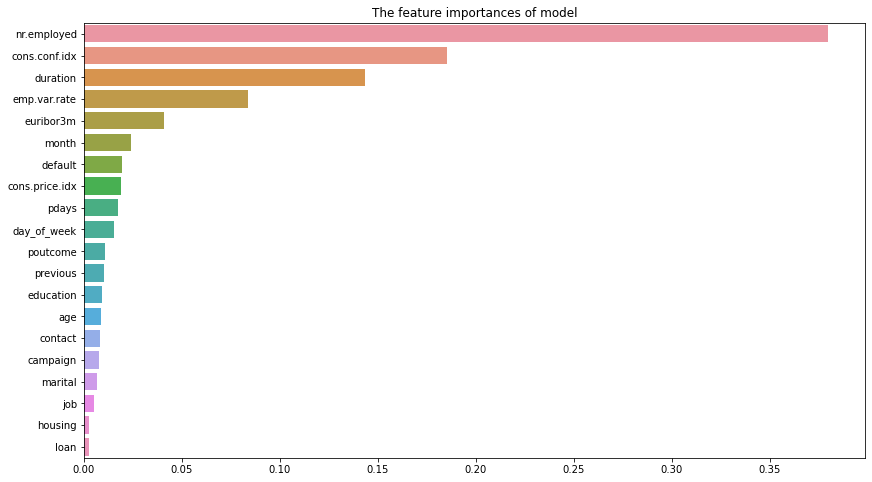

In [171]:
## Hệ số mô hình tối ưu
features = [i for i in under_mkt_df.columns.values.tolist() if i!= target]
opt_model_importances = pd.Series(data = optimal_model.feature_importances_, index = features, name = optimal_name)

plt.figure(figsize = (14,8))
sns.barplot(x = opt_model_importances.sort_values(ascending = False).values , y = opt_model_importances.sort_values(ascending = False).index)
plt.title('The feature importances of model')
plt.show()

## Visualize feature importances of the optimal model

### O P T I M A L    ROI on the whole dataset

In [168]:
### Real R O I on the whole dataset
## ROI = roi_per_success * # of sales - cost_per_call * # of calls
cost_per_call = 10
roi_per_success = 20
target = 'y'
# X_opt_test = process_mkt_df.drop(targer,axis = 1)
X_opt_test = scaler.transform(process_mkt_df.drop(target,axis = 1))
y_opt_test = process_mkt_df[target]

y_pred = optimal_model.predict(X_opt_test)

number_client = len(y_opt_test)
real_roi = get_real_roi(y_opt_test,cost_per_call,roi_per_success)
pred_roi = get_pred_roi(y_opt_test, y_pred)

print('The assumed cost_per_call is {}$  and roi_per_success is:{}$'.format(cost_per_call,roi_per_success))
print('The number of predicted clients is {}'.format(number_client))
print('The real revenue: '+str(real_roi)+"$")
print('The predicted revenue: '+str(pred_roi)+"$")
print('The PROFIT: '+str(pred_roi - real_roi)+'$')

The assumed cost_per_call is 10$  and roi_per_success is:20$
The number of predicted clients is 41176
The real revenue: -318980$
The predicted revenue: -10720$
The PROFIT: 308260$


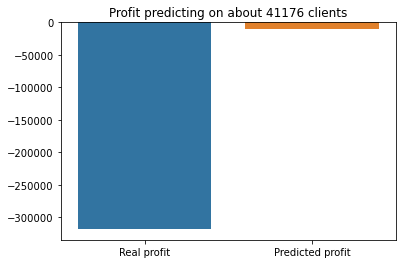

In [169]:
## visualize roi:
rois = [real_roi, pred_roi]
type_roi = ['Real profit', 'Predicted profit']
sns.barplot(y = rois , x = type_roi)
plt.title('Profit predicting on about {} clients'.format(number_client))
plt.show()


### R E S E A R C H   Decision tree

In [172]:
## init the research model
tree_model = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0)
tree_name = 'Decision Tree Classifier'
X_tree_train, X_tree_test, y_tree_train, y_tree_test = train_test_split(under_mkt_df.drop(target,axis=1),under_mkt_df[target],
                                                                            test_size=test_size, random_state = 101)

## Standardize data
X_tree_train = scaler.transform(X_tree_train)
X_tree_test = scaler.transform(X_tree_test)

tree_model.fit(X_tree_train,y_tree_train)
y_tree_test_pred = tree_model.predict(X_tree_test)

In [173]:
# ghi modelvào file pickle
with open("model/pkl_decisionT_model.pkl","wb") as f:
    pickle.dump(optimal_model,f)

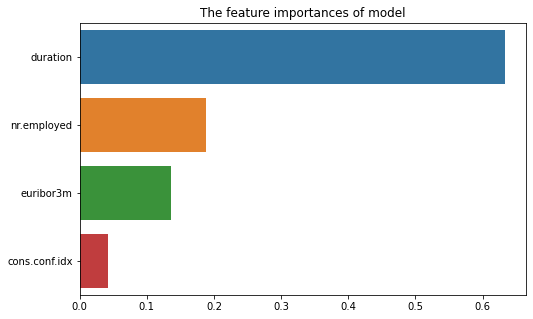

In [175]:
## Hệ số tree decision
features = [i for i in process_mkt_df.columns.values.tolist() if i!= target]
tree_model_importances = pd.Series(data = tree_model.feature_importances_, index = features, name = tree_name)
tree_model_importances = tree_model_importances[tree_model_importances > 0]

## The coefficients of the optimal model
## Visualize feature importances of the tree model
plt.figure(figsize = (8,5))
sns.barplot(x = tree_model_importances.sort_values(ascending = False).values , y = tree_model_importances.sort_values(ascending = False).index)
plt.title('The feature importances of model')
plt.show()

### V I S U A L I Z E  Decision Tree

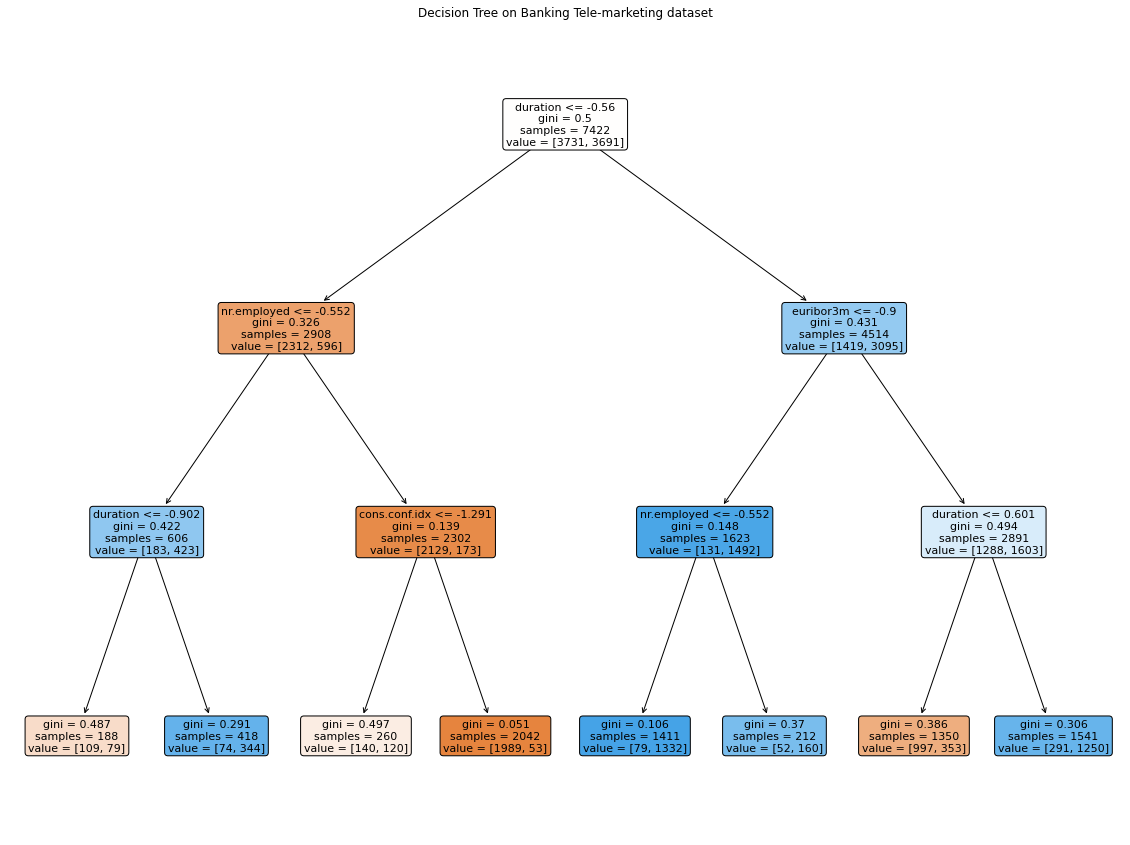

In [178]:
# from sklearn import tree
plt.figure(figsize=(20,15))

tree.plot_tree(tree_model,feature_names = features,rounded=True, filled = True);
plt.title("Decision Tree on Banking Tele-marketing dataset");